In [47]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

In [48]:
rho = 1
mu = 1
u_in = 1.5
D = 1
L = 10
tle = 10
v_i = -1.5
tau_0 = 10

# Papasnastasiou approximation
m = 10

In [49]:
geom = dde.geometry.Rectangle(xmin=[-L/2,-D/2],xmax=[L/2,D/2])

In [50]:
def upper_wall(X, on_boundary):
  # on_upper_wall = np.logical_and(np.isclose(X[1],D/2,rtol=1e-05,atol=1e-08), np.not_equal(X[0],-L/2), on_boundary)
  on_upper_wall = np.logical_and(np.logical_and(np.isclose(X[1],D/2,rtol=1e-05,atol=1e-08), np.not_equal(X[0],-L/2)), on_boundary)
  return on_upper_wall

def lower_wall(X, on_boundary):
  # on_lower_wall = np.logical_and(np.isclose(X[1],-D/2,rtol=1e-05,atol=1e-08), np.not_equal(X[0],-L/2),on_boundary)
  on_lower_wall = np.logical_and(np.logical_and(np.isclose(X[1],-D/2,rtol=1e-05,atol=1e-08), np.not_equal(X[0],-L/2)),on_boundary)
  return on_lower_wall

def boundary_inlet(X,on_boundary):
  on_inlet = np.logical_and(np.isclose(X[0],-L/2,rtol=1e-05,atol=1e-08),on_boundary)
  return on_inlet

def boundary_outlet(X,on_boundary):
  on_outlet = np.logical_and(np.isclose(X[0],L/2,rtol=1e-05,atol=1e-08),on_boundary)
  return on_outlet

In [51]:
bc_wall_u = dde.DirichletBC(geom, lambda X:v_i, upper_wall, component =0)
bc_wall_u = dde.DirichletBC(geom, lambda X:0., lower_wall, component =0)
bc_wall_v = dde.DirichletBC(geom, lambda X:0., upper_wall, component =1)
bc_wall_v = dde.DirichletBC(geom, lambda X:0., lower_wall, component =1)

bc_inlet_u = dde.DirichletBC(geom, lambda X:u_in, boundary_inlet, component =0)
bc_inlet_v = dde.DirichletBC(geom, lambda X:0., boundary_inlet, component =1)

bc_outlet_p = dde.DirichletBC(geom, lambda X:0., boundary_outlet, component =2)
bc_outlet_v = dde.DirichletBC(geom, lambda X:0., boundary_outlet, component =1)

In [52]:
def pde(X, Y):
    du_x = dde.grad.jacobian(Y, X, i=0, j=0)
    du_y = dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x = dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y = dde.grad.jacobian(Y, X, i=1, j=1)
    dp_x = dde.grad.jacobian(Y, X, i=2, j=0)
    dp_y = dde.grad.jacobian(Y, X, i=2, j=1)
    # du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    # du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    # dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    # dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)

    # Definições para Bingham para componentes do tensor de tensão
    tau_xy = tau_0 * (1 - tf.exp(- m * (du_y + dv_x))) + mu * (du_y + dv_x)
    tau_yx = tau_0 * (1 - tf.exp(- m * (dv_x + du_y))) + mu * (dv_x + du_y)
    tau_xx = tau_0 * (1 - tf.exp(- m * (du_x + du_x))) + mu * (du_x + du_x)
    tau_yy = tau_0 * (1 - tf.exp(- m * (dv_y + du_y))) + mu * (dv_y + du_y)
    # tau_xy = tau_0 * (1 - np.exp(- m * (du_y + dv_x))) + mu * (du_y + dv_x)
    # tau_yx = tau_0 * (1 - np.exp(- m * (dv_x + du_y))) + mu * (dv_x + du_y)
    # tau_xx = tau_0 * (1 - np.exp(- m * (du_x + du_x))) + mu * (du_x + du_x)
    # tau_yy = tau_0 * (1 - np.exp(- m * (dv_y + du_y))) + mu * (dv_y + du_y)

    # tau_diff = tau_xy - tau_0
    # H_tau = tf.where(tau_diff > 0, 1.0, 0.0)
    # dv_x = dde.grad.jacobian(Y, X, i=0, j=0) * H_tau
    # du_y = dde.grad.jacobian(Y, X, i=0, j=1) * H_tau
    
    # tau_xy = tau_0 + mu * (du_y + dv_x)
    # tau_yx = tau_0 + mu * (dv_x + du_y)
    # tau_xx = tau_0 + mu * (du_x + du_x)
    # tau_yy = tau_0 + mu * (dv_y + du_y)

    # Derivadas dos tensores de tensão
    dtau_xy_y = dde.grad.jacobian(tau_xy, X, i=0, j=1)
    dtau_yx_x = dde.grad.jacobian(tau_yx, X, i=0, j=0)
    dtau_xx_x = dde.grad.jacobian(tau_xx, X, i=0, j=0)
    dtau_yy_y = dde.grad.jacobian(tau_yy, X, i=0, j=1)

    # Equações de Navier-Stokes modificadas para incluir todos os tensores de tensão
    pde_u = rho * (Y[:,0:1] * du_x + Y[:,1:2] * du_y) + dp_x - dtau_yx_x - dtau_xx_x
    pde_v = rho * (Y[:,0:1] * dv_x + Y[:,1:2] * dv_y) + dp_y - dtau_xy_y - dtau_yy_y
    pde_cont = du_x + dv_y  # Equação de continuidade

    return [pde_u, pde_v, pde_cont]


In [53]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_wall_u,bc_wall_v,bc_inlet_u,bc_inlet_v,bc_outlet_p,bc_outlet_v],
                    num_domain = 5000,
                    num_boundary = 5000,
                    num_test = 10000)

<function matplotlib.pyplot.show(close=None, block=None)>

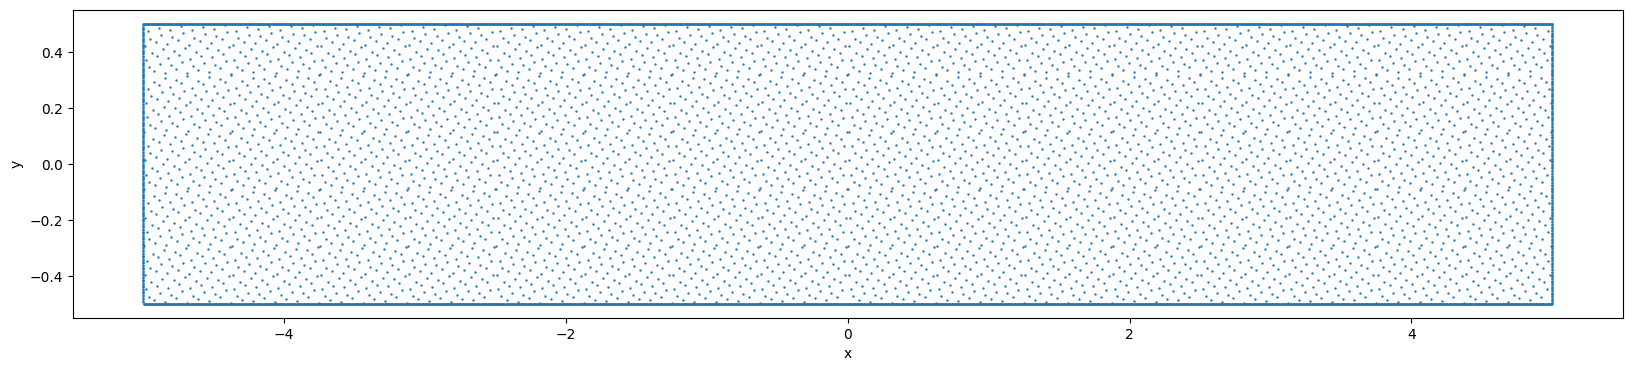

In [54]:
plt.figure(figsize=(20,4))
plt.scatter(data.train_x_all[:,0],data.train_x_all[:,1],s=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show

In [55]:
net = dde.maps.FNN([2]+[64]*5+[3], "tanh","Glorot uniform")

In [56]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.072210 s



c:\Users\Pablo\AppData\Local\pypoetry\Cache\virtualenvs\deepxde-custom-4PBOT-FI-py3.10\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.117031 s



In [57]:
losshistory,train_state = model.train(epochs = 10000, display_every=100)

Training model...

0         [6.07e+03, 1.32e+02, 1.41e-03, 5.25e-02, 9.00e-02, 1.49e+00, 1.21e-01, 5.06e-05, 1.21e-01]    [6.05e+03, 1.35e+02, 1.50e-03, 5.25e-02, 9.00e-02, 1.49e+00, 1.21e-01, 5.06e-05, 1.21e-01]    []  
100       [2.72e+00, 8.68e-01, 3.71e-01, 4.67e+00, 4.14e-02, 6.35e+00, 4.53e-02, 2.49e-03, 8.76e-04]    [2.59e+00, 6.99e-01, 3.92e-01, 4.67e+00, 4.14e-02, 6.35e+00, 4.53e-02, 2.49e-03, 8.76e-04]    []  
200       [3.67e-01, 1.49e-01, 1.12e-01, 2.99e+00, 1.04e-02, 1.80e+00, 1.61e-03, 1.99e-03, 1.65e-03]    [3.14e-01, 1.15e-01, 1.16e-01, 2.99e+00, 1.04e-02, 1.80e+00, 1.61e-03, 1.99e-03, 1.65e-03]    []  
300       [1.69e-01, 9.09e-02, 5.04e-02, 1.80e+00, 2.15e-03, 1.00e+00, 2.72e-04, 8.34e-04, 2.08e-03]    [1.43e-01, 6.68e-02, 5.17e-02, 1.80e+00, 2.15e-03, 1.00e+00, 2.72e-04, 8.34e-04, 2.08e-03]    []  
400       [1.86e-01, 8.77e-02, 3.01e-02, 1.21e+00, 2.47e-04, 7.87e-01, 1.56e-04, 8.26e-04, 3.11e-03]    [1.78e-01, 6.35e-02, 3.05e-02, 1.21e+00, 2.47e-04, 7.87e-01, 1.56

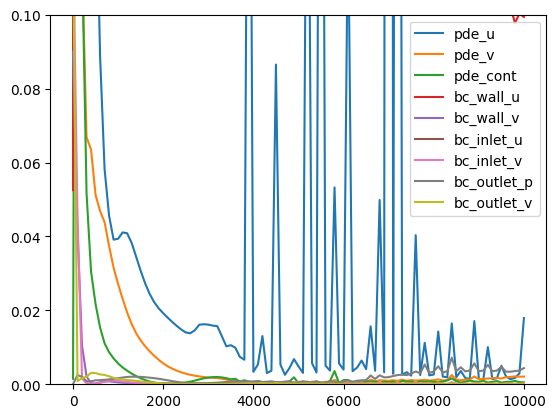

In [58]:
import matplotlib.pyplot as plt

plot_array = np.array(losshistory.loss_test)
plot_labels = ["pde_u", "pde_v", "pde_cont", "bc_wall_u", "bc_wall_v", "bc_inlet_u", "bc_inlet_v", "bc_outlet_p", "bc_outlet_v"]
# plot_array = np.array(losshistory.loss_train)
for i in range(plot_array.shape[1]):
    plt.plot(losshistory.steps, plot_array[:,i], label=plot_labels[i])
    
plt.legend()
plt.ylim([0, 0.1])
plt.show()

In [59]:
dde.optimizers.config.set_LBFGS_options(maxiter = 1000)
model.compile("L-BFGS")
losshistory,train_state = model.train()
dde.saveplot(losshistory, train_state, issave = False , isplot = False)

Compiling model...
'compile' took 2.862240 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
10000     [2.10e-02, 1.89e-03, 7.26e-04, 9.94e-02, 1.15e-04, 1.86e-01, 2.41e-04, 4.37e-03, 1.52e-04]    [1.79e-02, 2.07e-03, 5.39e-04, 9.94e-02, 1.15e-04, 1.86e-01, 2.41e-04, 4.37e-03, 1.52e-04]    []  
11000     [6.33e-03, 5.27e-03, 3.17e-03, 3.88e-02, 1.72e-04, 1.06e-01, 7.84e-04, 2.30e-04, 8.76e-05]    [6.33e-03, 5.27e-03, 3.17e-03, 3.88e-02, 1.72e-04, 1.06e-01, 7.84e-04, 2.30e-04, 8.76e-05]        
INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  Objective function value: 0.154359
  Number of iterations: 1000
  Number of functions evaluations: 1061
11061     [4.29e-03, 5.42e-03, 3.34e-03, 3.72e-02, 1.46e-04, 1.03e-01, 6.95e-04, 3.01e-04, 2.21e-04]    [6.46e-0

In [60]:
samples= geom.random_points(500000)
result = model.predict(samples)

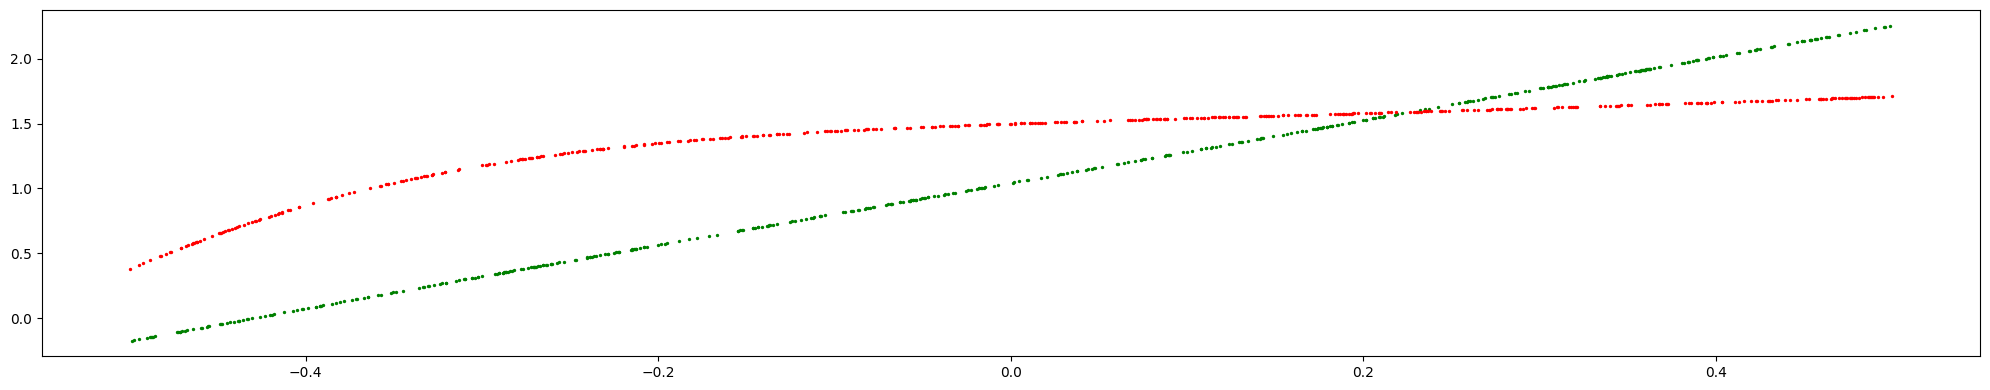

In [61]:
color_legend=[[0,1.5],[-0.3,0.3],[0,35]]
# for idx in range(3):
plt.figure(figsize=(20,4))
mask = np.where((samples[:,0] > 4.9) & (samples[:,0] < 4.91))
plt.scatter(samples[mask,1], result[mask,0], c='green',s=2)
mask = np.where((samples[:,0] < -4.9) & (samples[:,0] > -4.91))
plt.scatter(samples[mask,1], result[mask,0], c='red',s=2)
plt.tight_layout()
plt.show()

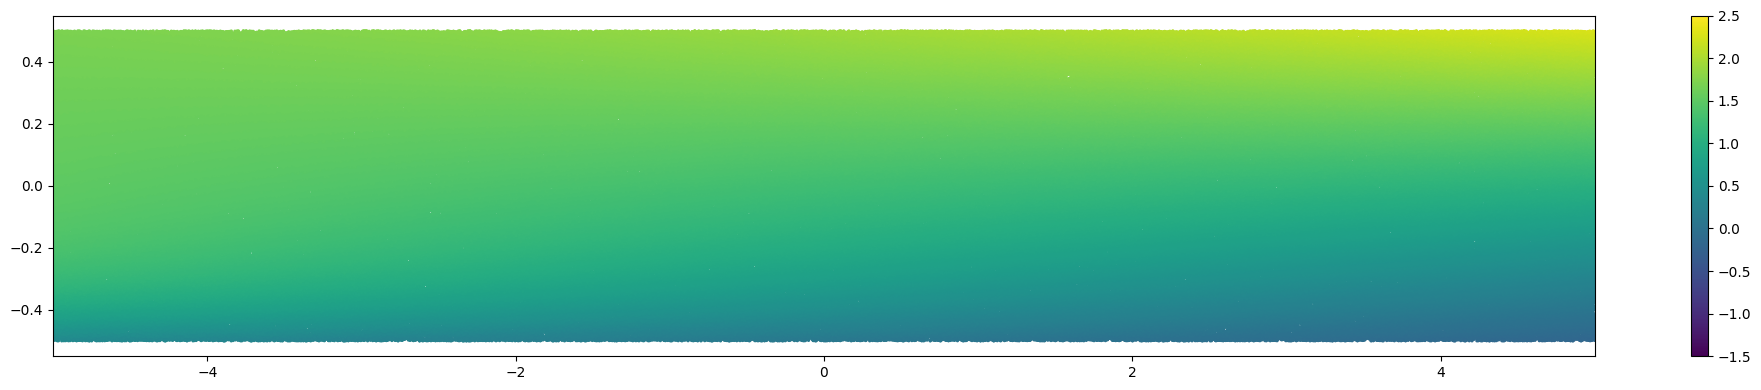

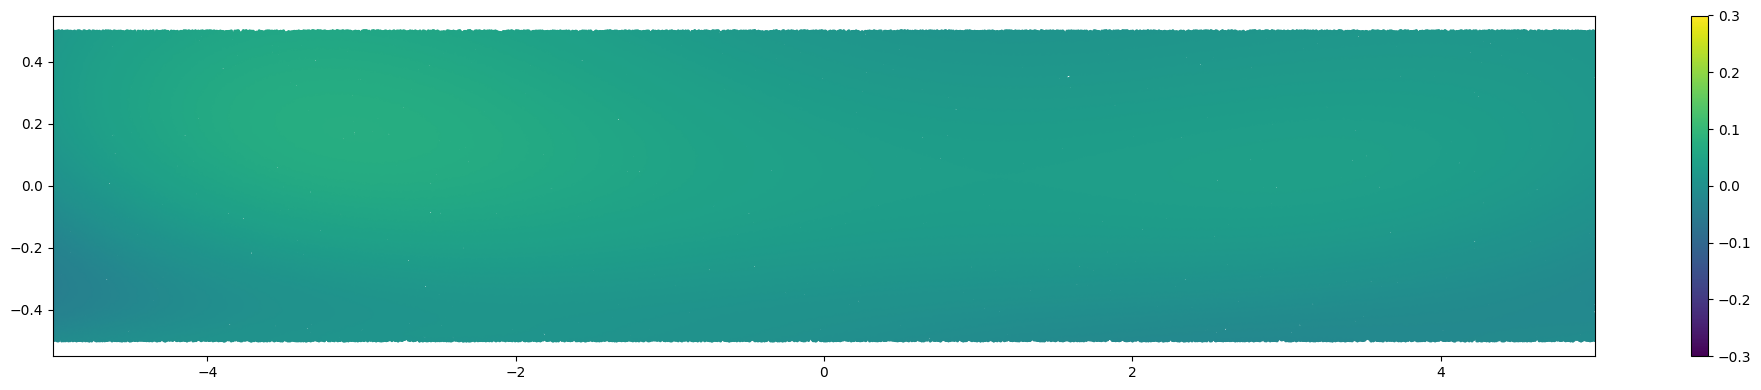

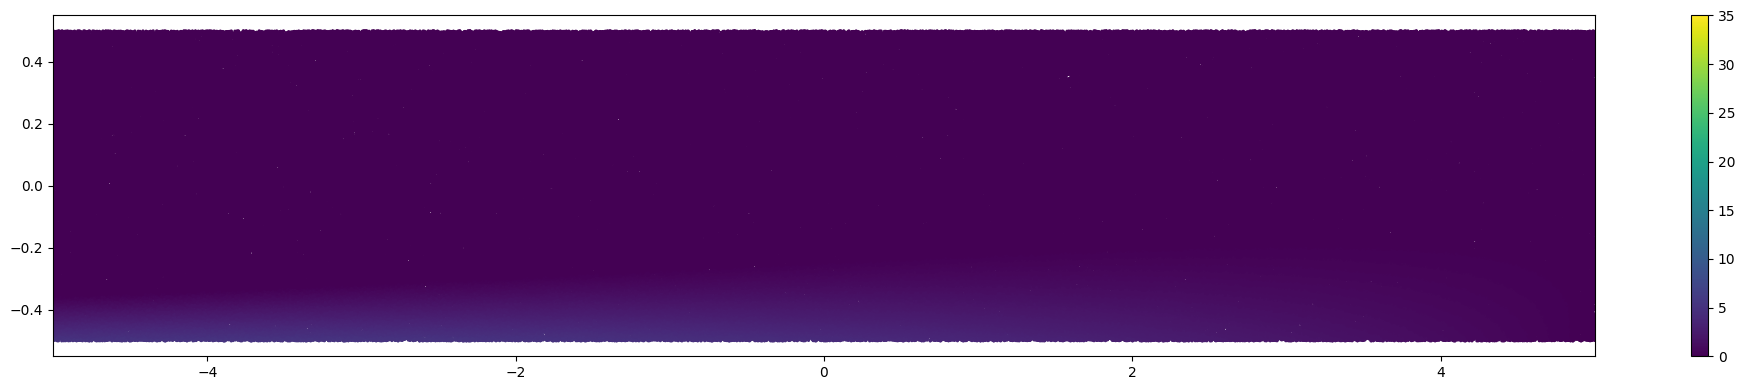

In [63]:
color_legend=[[-1.5,2.5],[-0.3,0.3],[0,35]]
for idx in range(3):
  plt.figure(figsize=(20,4))
  plt.scatter(samples[:,0], samples[:,1], c=result[:,idx], cmap='viridis',s=2)
  plt.colorbar()
  plt.clim(color_legend[idx])
  plt.xlim((0-D/2,D-D/2))
  plt.xlim((0-L/2,L-L/2))
  plt.tight_layout()
  plt.show()